## Regression Models

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### 1. Linear Regression

There are 2 very different ways to train it:

- Using a direct "closed-form" equation that directly computes the model parameters that best fit the model to the training set   (i.e., the model parameters that minimize the cost function over the training set)
- Using an iterative optimization approach called *Gradien Descent* that gradually tweaks the model parameters to minimize the   cost function over the training set

More generally, a linear model makes predictions by simply computing a weighted sum of the input features, plus a constant called the *bias term* (*intersept term*).


**The Normal Equation**

Generate some linear looking data to test this equation

In [2]:
x = 2 * np.random.rand(100, 1)
y = 4 + 3 * x + np.random.randn(100, 1)

Transform `x` and use the normal equation to find the best parameters

In [3]:
x_b = np.c_[np.ones((100, 1)), x]  # add x0 = 1 to each instance for the bias term

theta_best = np.linalg.inv(x_b.T.dot(x_b)).dot(x_b.T).dot(y)
theta_best

array([[3.77926689],
       [3.21163965]])

Now we can make predictions using `theta_best`

In [4]:
x_new = np.array([[0], [2]])
x_new_b = np.c_[np.ones((2, 1)), x_new]  # add x0 = 1 to each instance for the bias term

y_predict = x_new_b.dot(theta_best)
y_predict

array([[ 3.77926689],
       [10.20254618]])

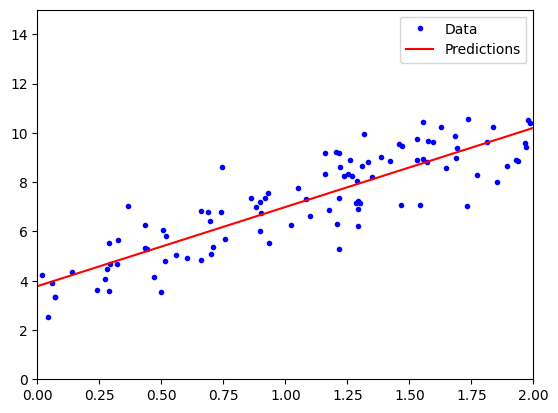

In [5]:
plt.plot(x, y, 'b.', label='Data')
plt.plot(x_new, y_predict, 'r-', label='Predictions')
plt.axis([0, 2, 0, 15]); plt.legend()
plt.show()

Performing Linear Regression using `Scikit-learn` is simple

In [6]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(x, y)  # no need to transform x

lin_reg.intercept_, lin_reg.coef_

(array([3.77926689]), array([[3.21163965]]))

In [7]:
lin_reg.predict(x_new)

array([[ 3.77926689],
       [10.20254618]])

The `LinearRegression` class is based on the `scipy.linalg.lstsq()` function

In [8]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(x_b, y, rcond=1e-6)
theta_best_svd

array([[3.77926689],
       [3.21163965]])

This function computes the *pseudoinverse* of X. You can compute it directly by

In [9]:
np.linalg.pinv(x_b).dot(y)

array([[3.77926689],
       [3.21163965]])

This approach based on *SVD decomposition* is more efficient than computing the Normal Equation, plus it handles edge cases nicely.

### 2. Gradient Descent

**Batch Gradient Descent**

A simple implementation

In [10]:
eta = 0.1  # learning rate
n_iterations = 1000
m = 100

theta = np.random.randn(2, 1)  # random initialization

for i in range(n_iterations):
    gradients = 2/m * x_b.T.dot(x_b.dot(theta) - y)
    theta -= eta * gradients

theta

array([[3.77926689],
       [3.21163965]])

That's exactly the same as the Normal Equation found.

**Stochastic Gradient Descent**

Randomness is good to escape from local minima, but bad because it means that the algorithm can never settle at the minimum. One solution is to gradually reduce the learning rate according to a *learning schedule*

In [11]:
n_epochs = 50
T0, T1 = 5, 50  # learning schedule hyperparameters

def learning_schedule(t: float) -> float:
    return T0 / (t + T1)

theta = np. random.randn(2, 1)  # random initialization

for epoch in range(n_epochs):
    for i in range(m):
        index = np.random.randint(m)
        xi = x_b[index:index+1]
        yi = y[index:index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta -= eta * gradients

theta

array([[3.73484914],
       [3.24938952]])

Using `Scikit-learn`

In [12]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=1e-1)
sgd_reg.fit(x, y.ravel())

sgd_reg.intercept_, sgd_reg.coef_

(array([3.79002698]), array([3.26041208]))

### 3. Polynomial Regression

You can use a linear model to fit nonlinear data

In [13]:
m = 100
x = 6 * np.random.rand(m, 1) - 3
y = 0.5 * x**2 + x + 2 + np.random.randn(m, 1)  # with Gaussian noise

Transform the training data, adding the square of each featur in the training set as a new feature

In [14]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2, include_bias=False)
x_poly = poly_features.fit_transform(x)

x[0], x_poly[0]

(array([-2.97094089]), array([-2.97094089,  8.82648979]))

Now you can fit a `LinearRegression` model to this extended training data

In [15]:
lin_reg = LinearRegression()
lin_reg.fit(x_poly, y)

lin_reg.intercept_, lin_reg.coef_  # expected 2, 1, 0.5 

(array([1.79660036]), array([[1.02576828, 0.51742676]]))

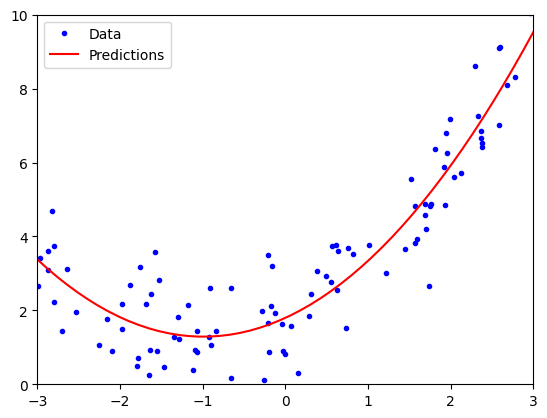

In [16]:
plt.plot(x, y, 'b.', label='Data')

t = np.linspace(-3, 3, num=50)
THETA_0, (THETA_1, THETA_2) = lin_reg.intercept_, lin_reg.coef_[0]
plt.plot(t,  THETA_0 + THETA_1 * t + THETA_2 * t**2, 'r-', label='Predictions')

plt.axis([-3, 3, 0, 10]); plt.legend()
plt.show()

`PolynomialFeatures` also adds combinations of features up to the given degree.

### 4. Learning Curve

These are plots of the model's performance on the training set and the validation set as a function of the training set size (or the training iteration). Usually the errors on the training data goes up until it reaches a plateau. As the model learns, the validation errors goes down.

In [17]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, x: np.ndarray, y: np.ndarray) -> None:
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2)
    
    train_errors, val_errors = list(), list()
    for m in range(1, len(x_train)):
        model.fit(x_train[:m], y_train[:m])
        y_train_predict = model.predict(x_train[:m])
        y_val_predict = model.predict(x_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
        
    plt.plot(np.sqrt(train_errors), 'r-+', linewidth=2, label='train_error')
    plt.plot(np.sqrt(val_errors), 'b-', linewidth=3, label='val_error')
    plt.xlabel('Training set size'); plt.ylabel('RMSE')
    plt.xlim(0, 80)

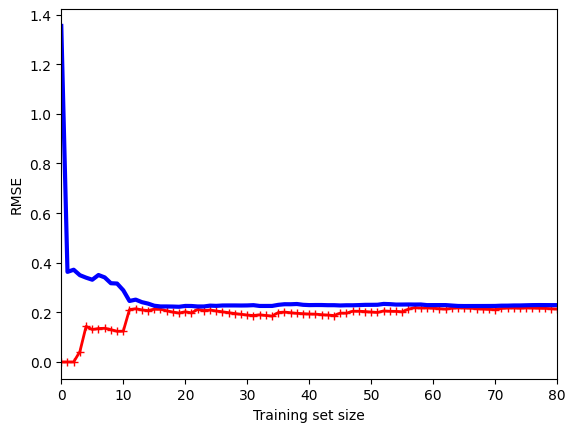

In [37]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, x, y)

There is almost no gap between the curves. These lines are typical of a model that's *underfitting*. Adding new instances to the training set can not improve errors.

Now let's look at the learning curves of a 5-th degree polinomial model on the same data

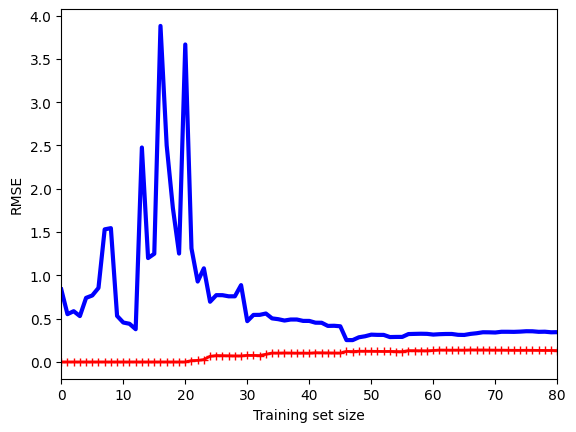

In [48]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
    ('poly_features', PolynomialFeatures(degree=5, include_bias=False)),
    ('lin_reg', LinearRegression())
])

plot_learning_curves(polynomial_regression, x, y)

These learning curves look a bit like the previous ones, but there are 2 very important differences:

- The error on the training data is much lower
- There is a bigger gap between the curves. This means that the model performs significantly better on the training data, which is a sign of an *overfitting* model. If you add more instances to train on the two curves would continue to get closer.

**The Bias/Variance Trade-off**

Increasing a model's complexity will typically increase its variance and reduce its bias. And vise versa.

### 5. Regularized Linear Models

For a linear model, regularization is typically achived by constraining the weights of the model.

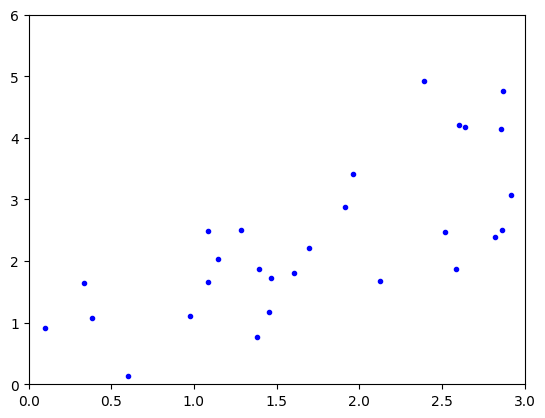

In [20]:
x = 3 * np.random.rand(30, 1)
y = 1 + x + np.random.randn(30, 1)

plt.plot(x, y, 'b.')
plt.xlim(0, 3); plt.ylim(0, 6); plt.show()

**Ridge Regression**

*Ridge Resression* is a regularized version of Linear Regression: a *regularization term* equal to half of the weighted sum of squared weights is added to the cost function.  

Using a closed-form solution

In [21]:
from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha=1, solver='cholesky')
ridge_reg.fit(x, y)
ridge_reg.intercept_, ridge_reg.coef_, ridge_reg.predict([[1.5]])

(array([0.26382509]), array([[1.14235432]]), array([[1.97735657]]))

Using SGD

In [22]:
sgd_reg = SGDRegressor(penalty='l2')
sgd_reg.fit(x, y.ravel())
sgd_reg.intercept_, sgd_reg.coef_, sgd_reg.predict([[1.5]])

(array([0.43284578]), array([1.06118462]), array([2.02462272]))

**Lasso Regression**

*Lasso Regression* is a regularized version of Linear Regression: a regularization term equal to weighted sum of weights is added to the cost function.

In [23]:
from sklearn.linear_model import Lasso

lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(x, y)
lasso_reg.intercept_, lasso_reg.coef_, lasso_reg.predict([[1.5]])

(array([0.38758119]), array([1.06724646]), array([1.98845088]))

In [24]:
sgd_reg = SGDRegressor(penalty='l1')
sgd_reg.fit(x, y.ravel())
sgd_reg.intercept_, sgd_reg.coef_, sgd_reg.predict([[1.5]])

(array([0.44137517]), array([1.05976641]), array([2.03102479]))

**Elastic Net**

*Elastic Net* is a middle ground between RidgeR and LassoR. The regularization term is just a mix of Ridge and Lasso's terms, and you can control the mix ratio *r*: *r* * LassoTerm + 0.5 * (1 - *r*) * RidgeTerm

In [25]:
from sklearn.linear_model import ElasticNet

elastic_reg = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_reg.fit(x, y)
elastic_reg.intercept_, elastic_reg.coef_, elastic_reg.predict([[1.5]])

(array([0.39391687]), array([1.06340132]), array([1.98901886]))

**Early Sropping**

A basic implementation

In [26]:
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler

# prepare the data
x = 6 * np.random.rand(m, 1) - 3
y = 0.5 * x**2 + x + 2 + np.random.randn(m, 1)  # with Gaussian noise

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2)

poly_scaler = Pipeline([
    ('poly_features', PolynomialFeatures(degree=90, include_bias=False)),
    ('std_scaler', StandardScaler())
])
x_train_poly_scaled = poly_scaler.fit_transform(x_train)
x_val_poly_scaled = poly_scaler.fit_transform(x_val)

# train the model
sgd_reg = SGDRegressor(
    max_iter=1, 
    tol=-np.infty, 
    warm_start=True, 
    penalty=None, 
    learning_rate='constant', 
    eta0=5e-4
)

min_val_error = float('inf')
best_epoch, best_model = None, None

for epoch in range(1000):
    sgd_reg.fit(x_train_poly_scaled, y_train.ravel())  # continues where it left off
    y_val_predict = sgd_reg.predict(x_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < min_val_error:
        min_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)

min_val_error, best_epoch

(1.090193455501216, 39)

### 6. Logistic Regression

*Logistic Regression* - a binary classifier with a threshold 0.5 that is commonly used to estimate probability that an instance belongs to a particular class. Just like a Linear Regression model, a Logistic Regression model computes a weighted sum of the input features (plus a bias term) and outputs the *logistic* of this result

Let's build a classifier to detect the *Iris virginica* based only on the petal width feature

In [27]:
from sklearn import datasets

iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [28]:
x = iris['data'][:, 3:]  # petal width
y = (iris['target'] == 2).astype(int)

In [29]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(x, y)

LogisticRegression()

`Scikit-learn` adds an L2 penalty by default.

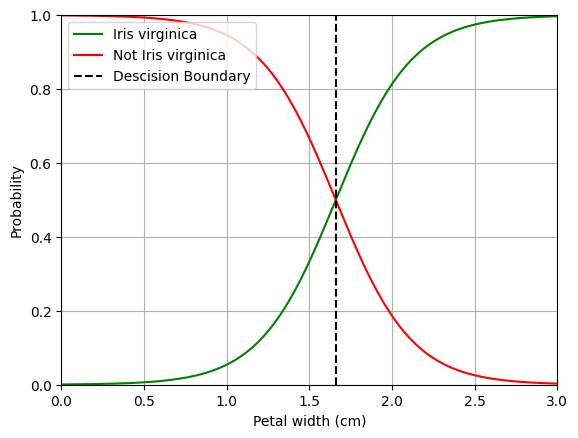

In [30]:
x_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(x_new)

plt.plot(x_new, y_proba[:, 1], 'g-', label='Iris virginica')
plt.plot(x_new, y_proba[:, 0], 'r-', label='Not Iris virginica')
plt.plot([1.664, 1.664], [0, 1], 'k--', label='Descision Boundary')
plt.ylim(0, 1); plt.xlim(0, 3)
plt.xlabel('Petal width (cm)'); plt.ylabel('Probability')
plt.legend(loc='upper left')
plt.grid()
plt.show()

There is a *descision boundary* at around 1.66 cm where both probabilities are equal to 50%

In [31]:
log_reg.predict([[1.7], [1.5]])

array([1, 0])

### 7. Softmax Regression

We can switch a Logistic Regression model that uses the OvR strategy for multiclass classification by default to a Softmax Regression model

In [32]:
x = iris['data'][:, (2,3)]  # petal length and width
y = iris['target']

In [33]:
softmax_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', C=10)
softmax_reg.fit(x, y)

LogisticRegression(C=10, multi_class='multinomial')

In [34]:
i = [[5, 2]]
softmax_reg.predict(i), softmax_reg.predict_proba(i)

(array([2]), array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]]))